Part 1: ingest data from Redshift

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
# !wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz

In [ ]:
# !tar xf spark-3.1.2-bin-hadoop2.7.tgz

In [1]:
# !pip install -q findspark
!pip install pyodbc

In [1]:
import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark import SparkContext, SparkConf,StorageLevel,SQLContext

from platform import python_version

print(python_version())

3.6.13


In [2]:
import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [3]:
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession

In [4]:
# Import Libraries
# import pyspark
# from pyspark import SparkConf, SparkContext
# import os

# Initialize Spark Context
# conf = SparkConf().setMaster("local").setAppName("MSDS436Final")
# sc = SparkContext(conf = conf)
sc = SparkSession.builder.appName("MLR").getOrCreate()


C:\Users\hag8665\Anaconda3\envs\new_environment\lib\site-packages\pyspark\context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


In [5]:
!pip install psycopg2
!pip install sqlalchemy-redshift

In [6]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

# connect to db
test_query = "select * from stuff where substring(date1,1,4) = '2022'"

red_engine = create_engine('---put your Query info we shut our Amazon Aurora RDS instance')

test = pd.read_sql_query(test_query,red_engine)
test.head()

,date1,_open,high,low,_close,adj_close,volume,ticker,date2,id,date3,probability,sentiment
0,2022-02-01 00:00:00,113.01000213623048,116.6500015258789,108.26000213623048,112.5999984741211,112.5999984741211,3461900.0,GME,2022-02-01,1488320213770772483,2022-02-01 01:16:05+00:00,0.7430091500282288,NEGATIVE
1,2022-02-01 00:00:00,113.01000213623048,116.6500015258789,108.26000213623048,112.5999984741211,112.5999984741211,3461900.0,GME,2022-02-01,1488320188718231555,2022-02-01 01:15:59+00:00,0.9245197772979736,NEGATIVE
2,2022-02-01 00:00:00,113.01000213623048,116.6500015258789,108.26000213623048,112.5999984741211,112.5999984741211,3461900.0,GME,2022-02-01,1488320173341818882,2022-02-01 01:15:55+00:00,0.7438493371009827,NEGATIVE
3,2022-02-01 00:00:00,113.01000213623048,116.6500015258789,108.26000213623048,112.5999984741211,112.5999984741211,3461900.0,GME,2022-02-01,1488320001987821569,2022-02-01 01:15:14+00:00,0.9439274668693542,NEGATIVE
4,2022-02-01 00:00:00,113.01000213623048,116.6500015258789,108.26000213623048,112.5999984741211,112.5999984741211,3461900.0,GME,2022-02-01,1488319945263964161,2022-02-01 01:15:01+00:00,0.8884325623512268,NEGATIVE


In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import numpy as np
enc = LabelEncoder()
test['sentiment1'] = enc.fit_transform(test['sentiment'])
#test['sentiment1'] = pd.Series(X)
test1 = test[['_open',	'high',	'low',	'_close',	'adj_close',	'volume','sentiment1']]
scaler = MinMaxScaler()
df = scaler.fit_transform(test1)
df = pd.DataFrame(df).reset_index()
df['ticker'] = test['ticker']
df.head()

,index,0,1,2,3,4,5,6,ticker
0,0,0.119454,0.121595,0.116233,0.11936,0.11936,0.020881,0.5,GME
1,1,0.119454,0.121595,0.116233,0.11936,0.11936,0.020881,0.5,GME
2,2,0.119454,0.121595,0.116233,0.11936,0.11936,0.020881,0.5,GME
3,3,0.119454,0.121595,0.116233,0.11936,0.11936,0.020881,0.5,GME
4,4,0.119454,0.121595,0.116233,0.11936,0.11936,0.020881,0.5,GME


In [8]:
!pip install graphframes

In [9]:
# reference: https://towardsdatascience.com/an-efficient-implementation-of-dbscan-on-pyspark-3e2be646f57d

from pyspark.sql import Row
import math
from graphframes import *
from itertools import combinations


def __distance_from_pivot(pivot, dist, epsilon, operations):
    def distance(x):
        pivot_dist = dist(x.value, pivot)
        if operations is not None:
            operations.add()
        partition_index = math.floor(pivot_dist / epsilon)
        rows = [Row(id=x.id, value=x.value, pivot_dist=dist(x.value, pivot))]
        out = [(partition_index, rows),
               (partition_index + 1, rows)]
        return out
    return distance


def __scan(epsilon, dist, operations):
    def scan(x):
        # out dictionary would have point id as key and a set of point ids who are within epsilon distance to
        # key point id. value is basically its neighbors
        out = {}
        # 0th index of x is partition_index
        # 1st index of x is data points
        partition_data = x[1]
        partition_len = len(partition_data)
        for i in range(partition_len):
            for j in range(i + 1, partition_len):
                if operations is not None:
                    operations.add()
                if dist(partition_data[i].value, partition_data[j].value) < epsilon:
                    # both i and j are within epsilon distance to each other
                    if partition_data[i].id in out:
                        out[partition_data[i].id].add(partition_data[j].id)
                    else:
                        out[partition_data[i].id] = set([partition_data[j].id])
                    if partition_data[j].id in out:
                        out[partition_data[j].id].add(partition_data[i].id)
                    else:
                        out[partition_data[j].id] = set([partition_data[i].id])
        # returns point and its neighbor as tuple
        return [Row(item[0], item[1]) for item in out.items()]

    return scan


def __label(min_pts):
    def label(x):
        if len(x[1]) + 1 >= min_pts:
            # use id as cluster label
            cluster_label = x[0]
            # return True for core point
            out = [(x[0], [(cluster_label, True)])]
            for idx in x[1]:
                # return False for base point
                out.append((idx, [(cluster_label, False)]))
            return out
        return []

    return label


def __combine_labels(x):
    # 0th element is the id of point
    # 1st element is the list of tuples with cluster and core point label
    point = x[0]
    core_point = False
    cluster_labels = x[1]
    clusters = []
    for (label, point_type) in cluster_labels:
        if point_type is True:
            core_point = True
        clusters.append(label)
    # if core point keep all cluster otherwise only one
    return point, clusters if core_point is True else [clusters[0]], core_point


def process(spark, df, epsilon, min_pts, dist, dim, checkpoint_dir, operations=None):
    """
    Process given dataframe with DBSCAN parameters
    :param spark: spark session
    :param df: input data frame where each row has id and value keys
    :param epsilon: DBSCAN parameter for distance
    :param min_pts: DBSCAN parameter for minimum points to define core point
    :param dist: method to calculate distance. Only distance metric is supported.
    :param dim: number of dimension of input data
    :param checkpoint_dir: checkpoint path as required by Graphframe
    :param operations: class for managing accumulator to calculate number of distance operations
    :return: A dataframe of point id, cluster component and boolean indicator for core point
    """
    zero = df.rdd.takeSample(False, 1)[0].value
    combine_cluster_rdd = df.rdd.\
        flatMap(__distance_from_pivot(zero, dist, epsilon, operations)). \
        reduceByKey(lambda x, y: x + y).\
        flatMap(__scan(epsilon, dist, operations)). \
        reduceByKey(lambda x, y: x.union(y)).\
        flatMap(__label(min_pts)).\
        reduceByKey(lambda x, y: x + y).map(__combine_labels).cache()
    id_cluster_rdd = combine_cluster_rdd.\
        map(lambda x: Row(point=x[0], cluster_label=x[1][0], core_point=x[2]))
    try:
        id_cluster_df = id_cluster_rdd.toDF()
        vertices = combine_cluster_rdd.\
            flatMap(lambda x: [Row(id=item) for item in x[1]]).toDF().distinct()
        edges = combine_cluster_rdd. \
            flatMap(lambda x: [Row(src=item[0], dst=item[1])
                               for item in combinations(x[1], 2)]). \
            toDF().distinct()
        spark.sparkContext.setCheckpointDir(checkpoint_dir)
        g = GraphFrame(vertices, edges)
        connected_df = g.connectedComponents()
        id_cluster_df = id_cluster_df.\
            join(connected_df, connected_df.id == id_cluster_df.cluster_label). \
            select("point", "component", "core_point")
        return id_cluster_df
    except ValueError:
        return None


__all__ = [process]

In [10]:
# process(spark, df, epsilon, min_pts, dist, dim, checkpoint_dir, operations=None)


In [11]:
from pyspark.sql import types as T, SparkSession
from scipy.spatial import distance
from pyspark.sql import SparkSession
#Create PySpark SparkSession
spark = SparkSession.builder.appName("DataFrame").getOrCreate()
#'_open',	'high',	'low',	'_close',	'adj_close',	'volume','sentiment1'
#T.StructField("id", T.IntegerType(), False),
schema = T.StructType([T.StructField("index", T.IntegerType(), False),
                       T.StructField("_open", T.FloatType(), False),
                       T.StructField("high", T.ArrayType(T.FloatType()), True),
                       T.StructField("low", T.ArrayType(T.FloatType()), True),
                       T.StructField("_close", T.ArrayType(T.FloatType()), True),
                       T.StructField("adj_close", T.ArrayType(T.FloatType()), True),
                       T.StructField("volume", T.ArrayType(T.FloatType()), True),
                       T.StructField("sentiment1", T.ArrayType(T.FloatType()), True)

                       ])
sparkDF=spark.createDataFrame(df)

#sparkDF = sparkDF.select("*").withColumn("index", monotonically_increasing_id())
sparkDF = sparkDF.withColumn("0",sparkDF['0'].cast('float'))
sparkDF = sparkDF.withColumn("1",sparkDF['1'].cast('float'))
sparkDF = sparkDF.withColumn("2",sparkDF['2'].cast('float'))
sparkDF = sparkDF.withColumn("3",sparkDF['3'].cast('float'))
sparkDF = sparkDF.withColumn("4",sparkDF['4'].cast('float'))
sparkDF = sparkDF.withColumn("5",sparkDF['5'].cast('float'))
sparkDF = sparkDF.withColumn("6",sparkDF['6'].cast('float'))
sparkDF = sparkDF.withColumn("index",sparkDF['index'].cast('float'))
#sparkDF = spark.createDataFrame(sparkDF,schema = schema)
sparkDF = sparkDF.repartition(10)
sparkDF.printSchema()

from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler().setInputCols(['0','1','2','3','4','5','6']).setOutputCol('value')
sparkDF1 = assembler.transform(sparkDF)
sparkDF1['index','value'].show()




root
 |-- index: float (nullable = true)
 |-- 0: float (nullable = true)
 |-- 1: float (nullable = true)
 |-- 2: float (nullable = true)
 |-- 3: float (nullable = true)
 |-- 4: float (nullable = true)
 |-- 5: float (nullable = true)
 |-- 6: float (nullable = true)
 |-- ticker: string (nullable = true)

+------+--------------------+
| index|               value|
+------+--------------------+
|   3.0|[0.11945366859436...|
|2469.0|[0.11660417914390...|
|3486.0|[0.02245313301682...|
|2853.0|[0.10740225017070...|
|1160.0|[0.05355115234851...|
|1345.0|[0.13075521588325...|
|1006.0|[0.10871987044811...|
|1721.0|[0.01452597789466...|
| 785.0|[0.02243170887231...|
| 457.0|[0.01402249652892...|
|2626.0|[3.21370862366165...|
|3274.0|[0.96843069791793...|
| 971.0|[0.05355115234851...|
|2712.0|[0.12949116528034...|
|2879.0|[0.01435457915067...|
|1134.0|[0.10871987044811...|
| 183.0|[0.01370112504810...|
| 153.0|[0.11945366859436...|
|1058.0|[0.01512587070465...|
|3678.0|[0.96843069791793...|
+-----

In [12]:
#out_test = process(spark,sparkDF1['index','value'],0.01,3,3,distance.euclidean,2,None)

In [122]:
from pyspark.ml.clustering import KMeans
kmeans = KMeans(k=9)
kmeans.setMaxIter(30)
kmeans.setFeaturesCol('value')
model = kmeans.fit(sparkDF1)
model.setPredictionCol("newPrediction")
transformed = model.transform(sparkDF1).select("value", "newPrediction","ticker")


In [66]:
summary = model.summary
print(summary)

In [ ]:
# load data and model output to redshit 
import pyodbc
import numpy as np
import io
import pandas as pd




df2 = np.array_split(df, 20)
for x in range(len(df2)):
    csv_buffer = io.StringIO()
    out_df = df2[x]
    csv_buffer = io.StringIO()
    out_df.to_csv(csv_buffer,header=False,index=False,date_format='%Y-%m-%d %H:%M:%S.%f')
    s3_resource = boto3.resource('s3')
    s3_resource.Object('msdsredshift436', f'redshiftparsed_{x}.csv').put(Body=csv_buffer.getvalue())



conn = pyodbc.connect ('DSN=AWS Redshift',autocommit=True)
conn.execute(""" copy stuff from 's3://msdsredshift436/'
    ACCESS_KEY_ID 'xxxxxxxxxxxxxx'
    SECRET_ACCESS_KEY 'xxxxxxxxxx'
    csv""")

In [67]:
# sparkDF1.show(1)#.to_csv('mycsv.csv')

In [78]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='newPrediction', featuresCol='value', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,102, 20):
    
    KMeans_algo=KMeans(featuresCol='value', k=i)
    
    KMeans_fit=KMeans_algo.fit(transformed)
    
    output=KMeans_fit.transform(transformed)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)

Silhouette Score: 0.8010366161840263
Silhouette Score: 0.8010366161840263
Silhouette Score: 0.8010366161840263
Silhouette Score: 0.8010366161840263
Silhouette Score: 0.8010366161840263


Text(0, 0.5, 'cost')

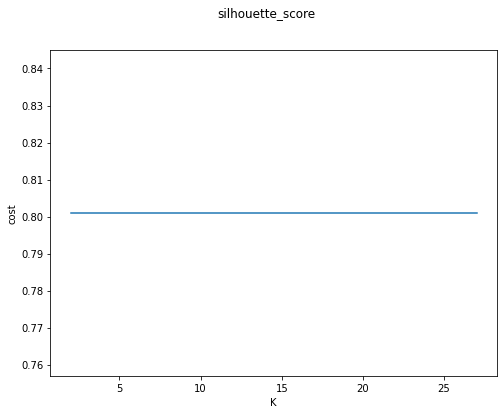

In [77]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
fig.suptitle('silhouette_score', fontsize=12)
ax.plot(range(2,30,5),silhouette_score)
ax.set_xlabel('K')
ax.set_ylabel('cost')


In [93]:
from sklearn.cluster import KMeans

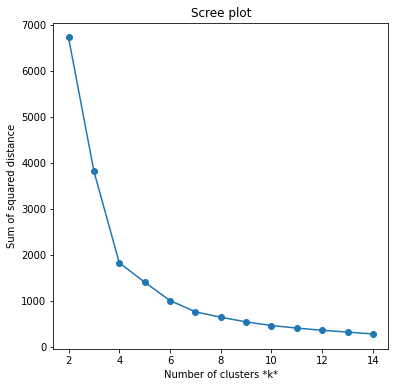

In [96]:
sse = []
list_k = list(range(2, 15))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(x)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.title('Scree plot')
plt.ylabel('Sum of squared distance');

In [123]:
df = transformed.toPandas()

In [124]:
df.head()

,value,newPrediction,ticker
0,"[0.012758435681462288, 0.013824154622852802, 0...",8,HOOD
1,"[0.012758435681462288, 0.013824154622852802, 0...",8,HOOD
2,"[0.012758435681462288, 0.013824154622852802, 0...",8,HOOD
3,"[0.012758435681462288, 0.013824154622852802, 0...",8,HOOD
4,"[0.012758435681462288, 0.013824154622852802, 0...",0,HOOD


In [125]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

In [126]:
def get_cluster_scatter_plot(X,  kmeans_labels, title):
    pca = PCA(n_components=2).fit(X)
    datapoint = pca.transform(X)

    plt.figure(figsize=(10, 6))
    label1 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']#, "#0000FF"]
    color = [label1[i] for i in kmeans_labels]
    #print(color)
    scatter = plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

#     centroids = kmeans_model.cluster_centers_
#     centroidpoint = pca.transform(centroids)
#     plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
    plt.title(title + ' PCA _k-means Cluster Plot')
    plt.show()

In [127]:
X = df['value'].values

In [128]:
X

array([DenseVector([0.0128, 0.0138, 0.0128, 0.0136, 0.0136, 0.1374, 0.5]),
       DenseVector([0.0128, 0.0138, 0.0128, 0.0136, 0.0136, 0.1374, 0.5]),
       DenseVector([0.0128, 0.0138, 0.0128, 0.0136, 0.0136, 0.1374, 0.5]),
       ..., DenseVector([0.0001, 0.0001, 0.0, 0.0, 0.0, 0.0, 1.0]),
       DenseVector([0.0001, 0.0001, 0.0, 0.0, 0.0, 0.0, 1.0]),
       DenseVector([0.1273, 0.13, 0.1281, 0.1309, 0.1309, 0.757, 0.0])],
      dtype=object)

In [129]:
x= []
for i in X:
    x.append(i)

In [130]:
labels  = df['newPrediction'].values

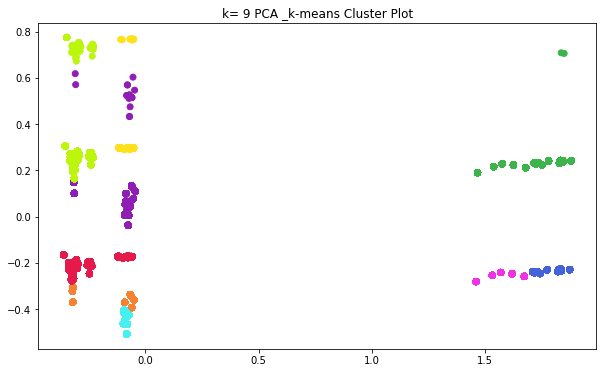

In [131]:
get_cluster_scatter_plot(x, labels, title = "k= 9")

In [132]:
pca = PCA(n_components=2)
traindata = pd.DataFrame(pca.fit_transform(x),columns=["x","y"])

In [133]:
traindata = traindata.assign(cluster=  labels)

In [134]:
traindata =traindata.assign(Stock = df.ticker)

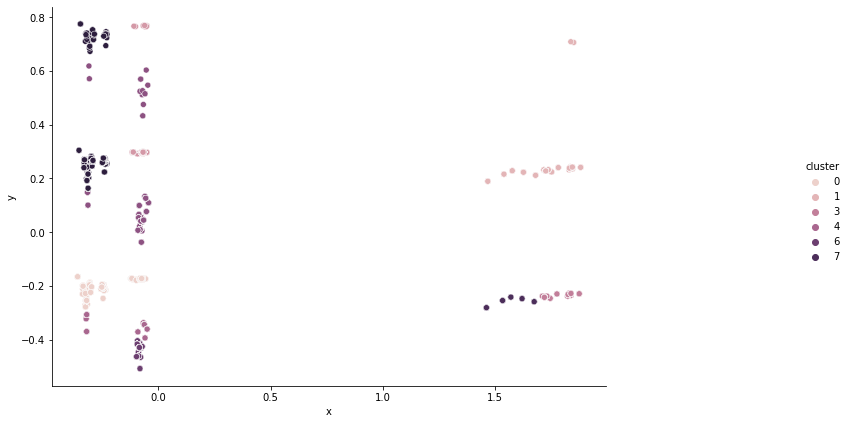

In [135]:
g = sns.pairplot(x_vars="x", y_vars="y", hue="cluster", data = traindata)
g.fig.set_size_inches(15, 7)

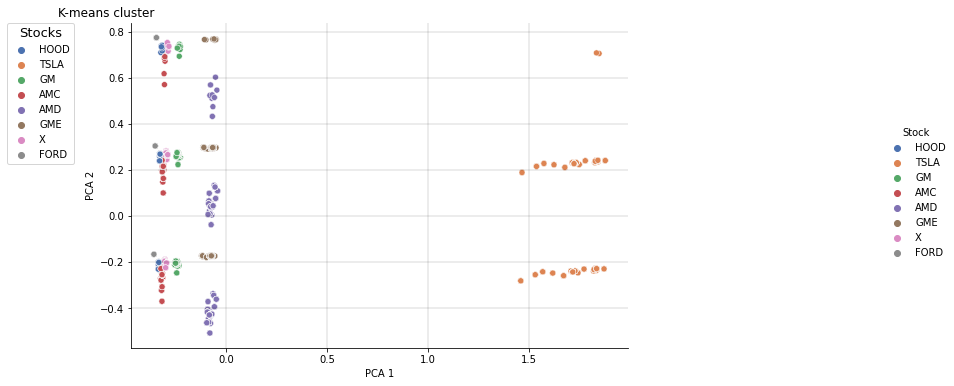

In [31]:
#plt.figure(figsize = (30,30))
# plt.figure(figsize = (20,20), tight_layout=True)

g= sns.pairplot(x_vars="x", y_vars="y", data = traindata, hue = "Stock", palette = "deep")
g.fig.set_size_inches(15, 6)
g.set(title='K-means cluster', xlabel='PCA 1', ylabel='PCA 2')
plt.legend(title='Stocks', title_fontsize='13', bbox_to_anchor=(-.25, 1), loc=2, borderaxespad=0.)
plt.grid(color='black', linestyle='-', linewidth=0.15)
plt.title('K-means cluster', y=1, x= -0.05)
plt.show()
# plt.title("K-means plot", fontsize = 15)
# plt.xlabel("pca 1", fontsize = 12)
# plt.ylabel("pca 2", fontsize = 12)



In [32]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [44]:
def dbscan(X, eps, min_samples):
    ss = StandardScaler()
    X = ss.fit_transform(X)
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(X)
    print(X)
    y_pred = db.fit_predict(X)
    plt.scatter(X[:,0], X[:,1],c=y_pred, cmap='Paired')
    plt.title("DBSCAN")
    return X , y_pred

[[-0.50064797 -0.50010642 -0.49947974 ... -0.49951318 -0.23599756
  -0.9876388 ]
 [-0.50064797 -0.50010642 -0.49947974 ... -0.49951318 -0.23599756
  -0.9876388 ]
 [-0.50064797 -0.50010642 -0.49947974 ... -0.49951318 -0.23599756
  -0.9876388 ]
 ...
 [-0.54383553 -0.54646542 -0.54341716 ... -0.54565348 -0.83376056
   0.98832326]
 [-0.54383553 -0.54646542 -0.54341716 ... -0.54565348 -0.83376056
   0.98832326]
 [-0.11006002 -0.10899018 -0.1015644  ... -0.09998431  2.46013438
  -2.96360085]]


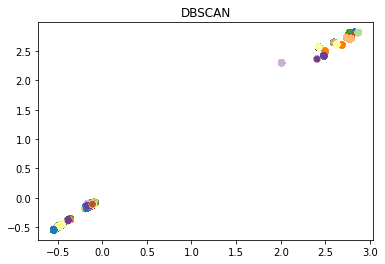

In [45]:
XX, y_pred= dbscan(x, eps=0.01, min_samples=2)

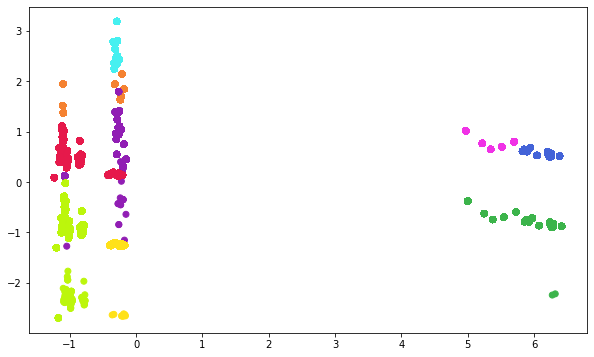

In [137]:
pca = PCA(n_components=2).fit(XX)
datapoint = pca.transform(XX)

plt.figure(figsize=(10, 6))
label1 = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']#, "#0000FF"]
color = [label1[i] for i in labels]
#print(color)
scatter = plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

In [61]:
XX,XX[:,1]

(array([[-0.50064797, -0.50010642, -0.49947974, ..., -0.49951318,
         -0.23599756, -0.9876388 ],
        [-0.50064797, -0.50010642, -0.49947974, ..., -0.49951318,
         -0.23599756, -0.9876388 ],
        [-0.50064797, -0.50010642, -0.49947974, ..., -0.49951318,
         -0.23599756, -0.9876388 ],
        ...,
        [-0.54383553, -0.54646542, -0.54341716, ..., -0.54565348,
         -0.83376056,  0.98832326],
        [-0.54383553, -0.54646542, -0.54341716, ..., -0.54565348,
         -0.83376056,  0.98832326],
        [-0.11006002, -0.10899018, -0.1015644 , ..., -0.09998431,
          2.46013438, -2.96360085]]),
 array([-0.50010642, -0.50010642, -0.50010642, ..., -0.54646542,
        -0.54646542, -0.10899018]))

In [40]:
from sklearn.manifold import TSNE

In [62]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(XX)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 51964 samples in 0.444s...
[t-SNE] Computed neighbors for 51964 samples in 1.315s...
[t-SNE] Computed conditional probabilities for sample 1000 / 51964
[t-SNE] Computed conditional probabilities for sample 2000 / 51964
[t-SNE] Computed conditional probabilities for sample 3000 / 51964
[t-SNE] Computed conditional probabilities for sample 4000 / 51964
[t-SNE] Computed conditional probabilities for sample 5000 / 51964
[t-SNE] Computed conditional probabilities for sample 6000 / 51964
[t-SNE] Computed conditional probabilities for sample 7000 / 51964
[t-SNE] Computed conditional probabilities for sample 8000 / 51964
[t-SNE] Computed conditional probabilities for sample 9000 / 51964
[t-SNE] Computed conditional probabilities for sample 10000 / 51964
[t-SNE] Computed conditional probabilities for sample 11000 / 51964
[t-SNE] Computed conditional probabilities for sample 12000 / 51964
[t-SNE] Computed conditional probabilities for sam

[Text(0.5, 1.0, 'DBSCAN T-SNE projection')]

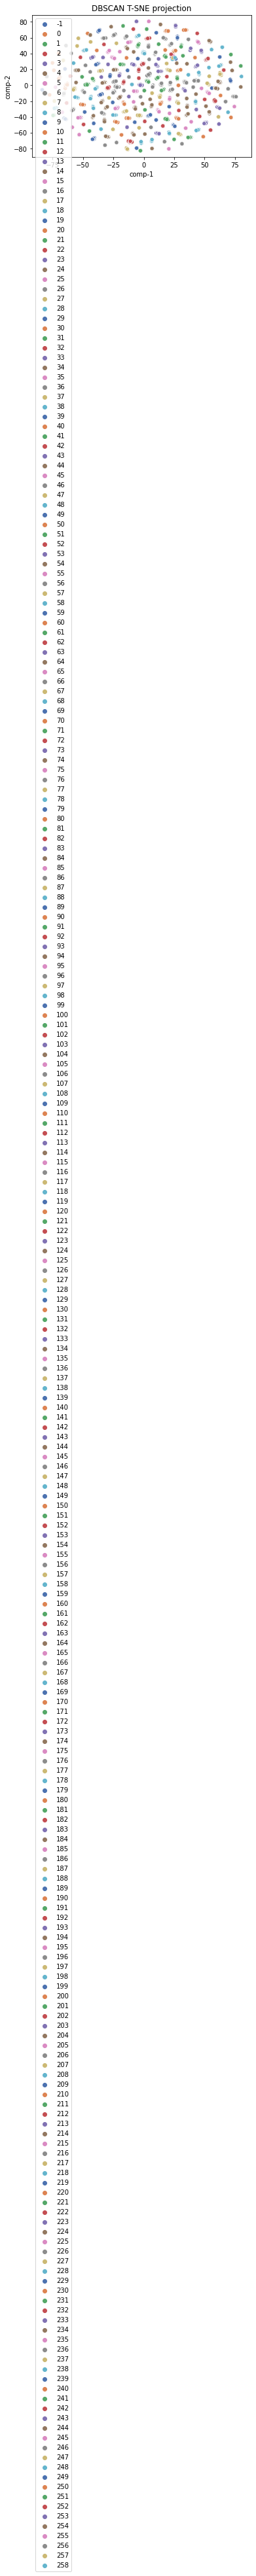

In [64]:
df = pd.DataFrame()
df["y"] = y_pred
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette="deep",
                data=df).set(title="DBSCAN T-SNE projection") 